In [1]:
import torch
import numpy as np
import cv2
import ipdb
import scipy

from torch import nn
from PIL import Image, ImageOps
import matplotlib.pyplot as plt


from numpy import dot
from numpy.linalg import matrix_rank, inv
from numpy.random import permutation
from scipy.linalg import eigh
from scipy.linalg import norm as mnorm

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

import os


from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA

import ica

from util import entropyLoss, getdata, infomaxICA

In [2]:

file_name = os.listdir('./data')
dir_list = []
for name in file_name[1:4]:
    dir_list.append('./data/'+name)
num_of_img = len(dir_list)
resize = 128

In [25]:
array_list=[]

for img_dir in dir_list:
    image = Image.open(img_dir)
    image = np.array(ImageOps.grayscale(image))
    image = cv2.resize(image, (resize, resize))
#     image = torch.from_numpy(image).float().flatten()
    image = np.expand_dims(image.flatten(), axis=0)
    array_list.append(image)

img_concate = np.concatenate(array_list)

A = np.random.normal(0, 0.5, size=(num_of_img,num_of_img))
mixture = A@img_concate

print(A, img_concate.shape, sep='\n')

print('condition number:', np.linalg.cond(A))


[[-0.46218929 -0.63904715 -0.39348625]
 [-0.42883304 -0.08091965  0.62095244]
 [-1.01306268  0.20680869 -0.10350006]]
(3, 16384)
condition number: 2.1476970931105046


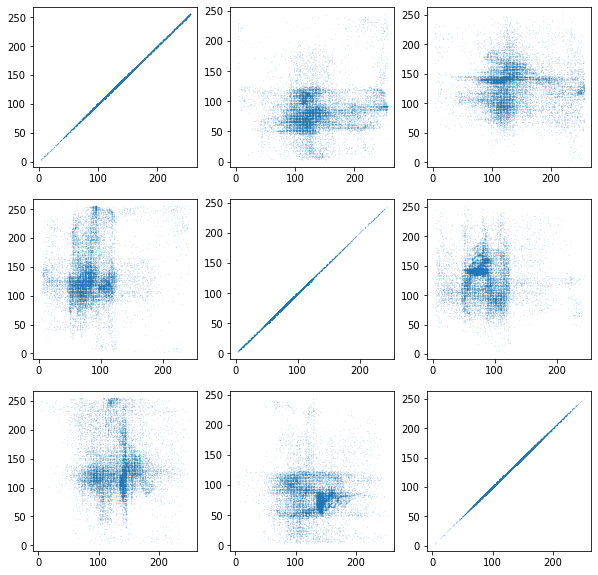

In [26]:
plt.figure(figsize=(10,10))

sub_shape = num_of_img

for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(img_concate[i, :], img_concate[j, :], '.', ms=0.1)

In [27]:
A0, r, W = ica.ica1(mixture, num_of_img, verbose=True)
# print(w)

Whitening data...
x_white shape: 3, 16384
Done.
Running INFOMAX-ICA ...
Beginning ICA training...
Step 57: Lrate 1.4e-05,Wchange 6.0e-07,Angle 65.40
Done.


In [28]:
np.linalg.cond(W)

1.094126334422748

# plot of ica.ica1 output

In [29]:
# plt.figure(figsize=(10,10))

# sub_shape = num_of_img

# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(r[i], r[j], '.', ms=0.1)

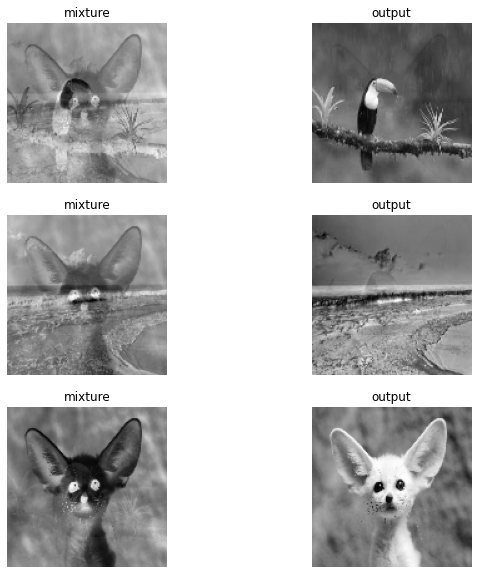

In [30]:
%matplotlib inline

plt.figure(figsize=(10,10))
for i in range(num_of_img):
    plt.subplot(num_of_img, 2, i*2+1)
    plt.imshow(np.reshape(mixture[i], (resize,resize)), cmap='gray')
    plt.title('mixture')
    plt.axis('off')
    
    plt.subplot(num_of_img, 2, i*2+2)
    plt.imshow(np.reshape(r[i], (resize,resize)), cmap='gray')
    plt.title('output')
    plt.axis('off')

In [31]:
#data whitening
# minim = np.expand_dims(np.min(mixture, axis=1),1)
# maxim = np.expand_dims(np.max(mixture, axis=1),1)
# mixture = (mixture-minim)/(maxim-minim)

x_white, white, dewhite = ica.pca_whiten(mixture, 3)
IPT = x_white
IPT = torch.from_numpy(IPT).type(torch.float32)

# minim = torch.min(IPT, axis=1)[0].unsqueeze(1)
# maxim = torch.max(IPT, axis=1)[0].unsqueeze(1)
# IPT = (IPT-minim)/(maxim-minim)

# Original images

In [32]:
# %matplotlib inline

# plot_bound = int(np.ceil(np.sqrt(num_of_img)))

# plt.figure(figsize=(10,10))
# for i in range(num_of_img):
#     plt.subplot(plot_bound, plot_bound, i+1)
#     plt.imshow(np.reshape(array_list[i], (resize,resize)), cmap='gray')

# Mixed images

In [33]:
# %matplotlib inline

# plot_bound = int(np.ceil(np.sqrt(num_of_img)))

# plt.figure(figsize=(10,10))
# for i in range(num_of_img):
#     plt.subplot(plot_bound, plot_bound, i+1)
#     plt.imshow(np.reshape(mixture[i,:], (resize,resize)), cmap='gray')

# Whitened images

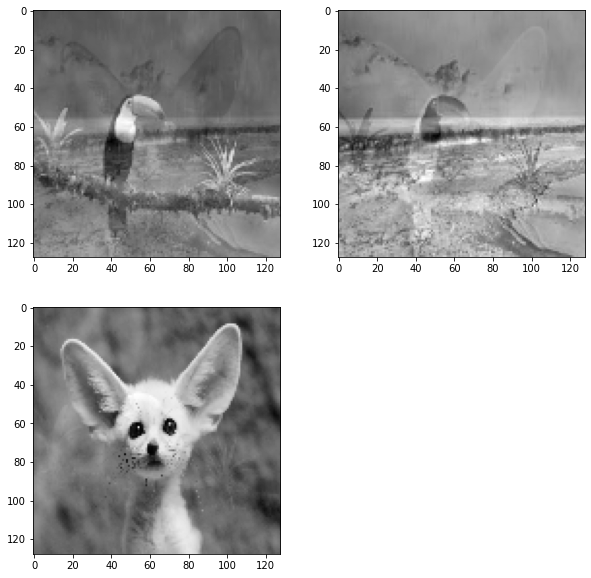

In [34]:
%matplotlib inline

plot_bound = int(np.ceil(np.sqrt(num_of_img)))

plt.figure(figsize=(10,10))
for i in range(num_of_img):
    plt.subplot(plot_bound, plot_bound, i+1)
    plt.imshow(np.reshape(IPT[i,:], (resize,resize)), cmap='gray')

# The original sources

In [35]:
# plt.figure(figsize=(10,10))

# sub_shape = num_of_img

# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(img_concate[i, :], img_concate[j, :], '.', ms=0.1)

# The mixture of sources

In [36]:
# plt.figure(figsize=(10,10))

# sub_shape = num_of_img

# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(mixture[i, :], mixture[j, :], '.', ms=0.1)

# The whitened source

In [37]:
# plt.figure(figsize=(10,10))

# sub_shape = num_of_img

# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(IPT[i, :], IPT[j, :], '.', ms=0.1)

In [38]:
device = torch.device('cuda:0')

In [39]:
model = infomaxICA(num_of_img)

In [40]:

dataset = getdata(IPT)
sampler = RandomSampler(dataset)
loader = DataLoader(dataset=dataset, sampler=sampler, batch_size=64)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=0.001,
                             eps=10e-4,
#                              weight_decay = 1e-5,
                            )


num_epoch = 300
# scheduler = CosineAnnealingLR(optimizer, T_max = num_epoch)
scheduler = OneCycleLR(optimizer, 0.1, steps_per_epoch=len(loader), epochs=num_epoch)

# np.linalg.inv(model.W2.weight.data)

In [41]:
model = model.to(device)
IPT = IPT.to(device)

In [42]:
loss_tracker = []

In [43]:
# %matplotlib notebook
# fig = plt.figure(figsize=(12,5))
# ax = fig.add_subplot(131)
# ax1 = fig.add_subplot(132)
# ax2 = fig.add_subplot(133)

# trace = []

for epoch in range(num_epoch):
    for step, ipt in enumerate(loader):
        model.zero_grad()
        ipt = ipt.to(device)
        
        opt = model.forward(ipt)
        loss = entropyLoss(opt.T, device=device)
#         loss = entropyLoss(opt.permute(1,0))
#         optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0, norm_type=2)
        optimizer.step()
    
    loss = loss.cpu()
    loss_tracker.append(loss.detach().numpy())
#     if epoch % 3 == 0:
#         ax.clear()
#         ax.plot(loss_tracker)
#         fig.canvas.draw()
        
#         with torch.no_grad():
#             data = model.forward(IPT.T).cpu().detach().numpy()
#         ax1.clear()
#         ax1.plot(data[:, 0], data[:, 1], '.', ms=0.5)
#         fig.canvas.draw()
        
# #         data2 = (model.W2.weight.data@IPT).cpu()
# #         ax2.clear()
# #         ax2.plot(data2.T[:, 0], data2.T[:, 1], '.', ms=0.5)
# #         fig.canvas.draw()

#         data2 = (model.W2.weight.data@IPT).cpu().detach().numpy()
# #         trace.append(data[300,:])
# #         trace.append(data2[:,100])
#         ax2.clear()
# #         ax2.plot(np.array(trace)[:, 0], np.array(trace)[:, 1])
#         ax2.plot(data2.T[:, 0], data2.T[:, 1], '.', ms=0.5)
#         fig.canvas.draw()
    
    print(epoch, loss.detach().numpy())
#     scheduler.step()

0 nan
1 nan
2 nan
3 nan
4 nan
5 nan
6 nan


KeyboardInterrupt: 

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.plot(loss_tracker)

In [ ]:
model.cpu()
IPT = IPT.cpu()
# np.linalg.inv(model.W2.weight.data)

In [ ]:
print('the condition number of weight:', np.linalg.cond(model.W2.weight.data))

In [ ]:
model.W2.weight.data

In [ ]:
with torch.no_grad():
    data = model.forward(IPT.T).detach().numpy() # B.detach().numpy()#
data.shape

In [ ]:
data2 = model.W2.weight.data@IPT

scale = data2.std(axis=1).reshape((-1, 1))
data2 = data2 / scale

In [ ]:
%matplotlib inline

plt.figure(figsize=(10,10))
for i in range(num_of_img):
    plt.subplot(num_of_img, 3, i*3+1)
    plt.imshow(np.reshape(array_list[i], (resize,resize)), cmap='gray')
    plt.title('original')
    plt.axis('off')
    
    plt.subplot(num_of_img, 3, i*3+2)
    plt.imshow(np.reshape(mixture[i], (resize,resize)), cmap='gray')
    plt.title('mixture')
    plt.axis('off')
    
    plt.subplot(num_of_img, 3, i*3+3)
    plt.imshow(np.reshape(data2.T[:, i], (resize,resize)), cmap='gray')
    plt.title('output')
    plt.axis('off')

In [ ]:
# the input whitened mixtures
plt.figure(figsize=(10,10))

sub_shape = num_of_img

for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(IPT[i, :], IPT[j, :], '.', ms=0.1)

In [ ]:
#plot of output from the model

plt.figure(figsize=(10,10))

sub_shape = num_of_img

for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(data[:, i], data[:, j], '.', ms=0.1)


In [ ]:
#plot of output from the model without sigmoid

plt.figure(figsize=(10,10))

sub_shape = num_of_img

for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(data2.T[:, i], data2.T[:, j], '.', ms=0.1)

In [ ]:
plt.figure(figsize=(10,10))

sub_shape = num_of_img

for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(img_concate[i, :], img_concate[j, :], '.', ms=0.1)

In [ ]:
print(np.linalg.inv(model.W2.weight.data), A, s)

In [ ]:
orig = (img_concate-img_concate.min())/(img_concate.max()-img_concate.min())
print('the original image:', entropyLoss(torch.tensor(orig), use_gpu=False), orig.shape)

In [ ]:
print('the output:', entropyLoss(torch.tensor(data.T), use_gpu=False), data.shape)

In [ ]:
Norm_X = (IPT-IPT.min())/(IPT.max()-IPT.min())
print('the whitened data:', entropyLoss(Norm_X, use_gpu=False), IPT.shape)

In [ ]:
rand_data = np.random.rand(5, resize**2)
print('random uniformal data:', entropyLoss(torch.from_numpy(rand_data).float(), use_gpu=False), data.shape)

In [ ]:
np.linalg.inv(model.W2.weight.data.detach().numpy())*100@A

In [ ]:
A